In [43]:
# General imports
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.visualization import plot_distribution

# Estimator & Sampler for optimization in a full simulated environement
from qiskit.primitives import StatevectorEstimator
from qiskit.primitives import StatevectorSampler

# SciPy minimizer routine
from scipy.optimize import minimize

# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw


In [44]:
# Define the hamiltonian
num_qubits = 3     # TBD -/- number of assests considered

# Define mean returns for oil, gold, and wheat
μ = mean_returns = np.array([0.05, 0.03, 0.04])  # in decimal (5%, 3%, 4%)

# Define standard deviations for oil, gold, and wheat
stds = np.array([0.08, 0.06, 0.07])  # in decimal (8%, 6%, 7%)

# Create a correlation matrix
corr_matrix = np.array([[1.0, 0.4, 0.3],  # Oil-gold correlation: 0.4, oil-wheat correlation: 0.3
                        [0.4, 1.0, 0.2],  # Gold-wheat correlation: 0.2
                        [0.3, 0.2, 1.0]]) # Diagonal entries are 1.0, representing perfect correlation with itself

# Create the covariance matrix
Σ = np.diag(stds) @ corr_matrix @ np.diag(stds)  # Covariance matrix

alpha = 0.5  # For example, the total allocation should not exceed 50%

# Define the upper bounds for individual weights to ensure the sum does not exceed alpha
bounds = [ alpha/num_qubits, alpha/num_qubits, alpha/num_qubits]

# alpha the boundaries of assets repartition
α = bounds


# Arbitrary values for the parameters of the Lagrangian penalties
λ = 1e3 # Adjust based on the desired strength of the Lagrangian penalties

# Arbitrary values for the parameters of the Beta penalties
β = 1e3 # Adjust based on the desired strength of the Beta penalties

si = bounds # Initial values for the parameters




In [45]:
# Define the coefficients and Pauli operators
paulis = []

# First term: ZZ interactions
for i in range(num_qubits):
    for j in range(i+1, num_qubits): 
        coeff = Σ[i, j] / 4
        print(f"Pauli coef for qubit interraction of {i} on {j} : {coeff}")
        if  i == 0 :
            pauli_str = 'Z' + 'I'*(j-i-1) + 'Z' + 'I'*(max(num_qubits-j-1,0))
            paulis.append((pauli_str, coeff))
        if  i == 1 :
            pauli_str = 'I'+'ZZ'
            paulis.append((pauli_str, coeff))

# Second term: single qubit terms
for i in range(num_qubits):
    coeff = -1*(sum((Σ[i, j]/ 2) for j in range(num_qubits))  - ((λ * μ[i]) / 2) + β * (1/2 + si[i] - α[i]))
    print(f"Single qubit coefficient ({i}): {coeff}")
    if i == 0:
        paulis.append(('ZII', coeff+ (β / 2)))
    if i == 1: 
        paulis.append(('IZI',coeff + (β / 2)))
    if i == 2: 
        paulis.append(('IIZ', coeff + (β / 2)))

# Third term: Z^2 terms
for i in range(num_qubits):
    coeff = β / 2
    print(f"Z^2 coefficient ({i}): {coeff}")
    if i == 0:
        paulis.append(('ZII', coeff))
    if i == 1: 
        paulis.append(('IZI',coeff))
    if i == 2: 
        paulis.append(('IIZ', coeff))

# Fourth term: constant shift
const_shift = -1*sum( sum(Σ[i, j] / 4 for j in range(num_qubits))  - ((λ * μ[i])/ 2) - β * ((si[i] - α[i])**2 + (si[i] - α[i]) + 1/4) for i in range(num_qubits))
print(f"Constant shift: {const_shift}")
paulis.append(('III',const_shift))
print(paulis)


Pauli coef for qubit interraction of 0 on 1 : 0.00048
Pauli coef for qubit interraction of 0 on 2 : 0.00042000000000000007
Pauli coef for qubit interraction of 1 on 2 : 0.00021000000000000004
Single qubit coefficient (0): -408.33833333333337
Single qubit coefficient (1): -418.33651333333336
Single qubit coefficient (2): -413.3370433333334
Z^2 coefficient (0): 500.0
Z^2 coefficient (1): 500.0
Z^2 coefficient (2): 500.0
Constant shift: 623.3273883333334
[('ZZI', 0.00048), ('ZIZ', 0.00042000000000000007), ('IZZ', 0.00021000000000000004), ('ZII', 91.66166666666663), ('IZI', 81.66348666666664), ('IIZ', 86.66295666666662), ('ZII', 500.0), ('IZI', 500.0), ('IIZ', 500.0), ('III', 623.3273883333334)]


In [46]:
hamiltonian = SparsePauliOp.from_list(paulis)
print(hamiltonian)

SparsePauliOp(['ZZI', 'ZIZ', 'IZZ', 'ZII', 'IZI', 'IIZ', 'ZII', 'IZI', 'IIZ', 'III'],
              coeffs=[4.80000000e-04+0.j, 4.20000000e-04+0.j, 2.10000000e-04+0.j,
 9.16616667e+01+0.j, 8.16634867e+01+0.j, 8.66629567e+01+0.j,
 5.00000000e+02+0.j, 5.00000000e+02+0.j, 5.00000000e+02+0.j,
 6.23327388e+02+0.j])


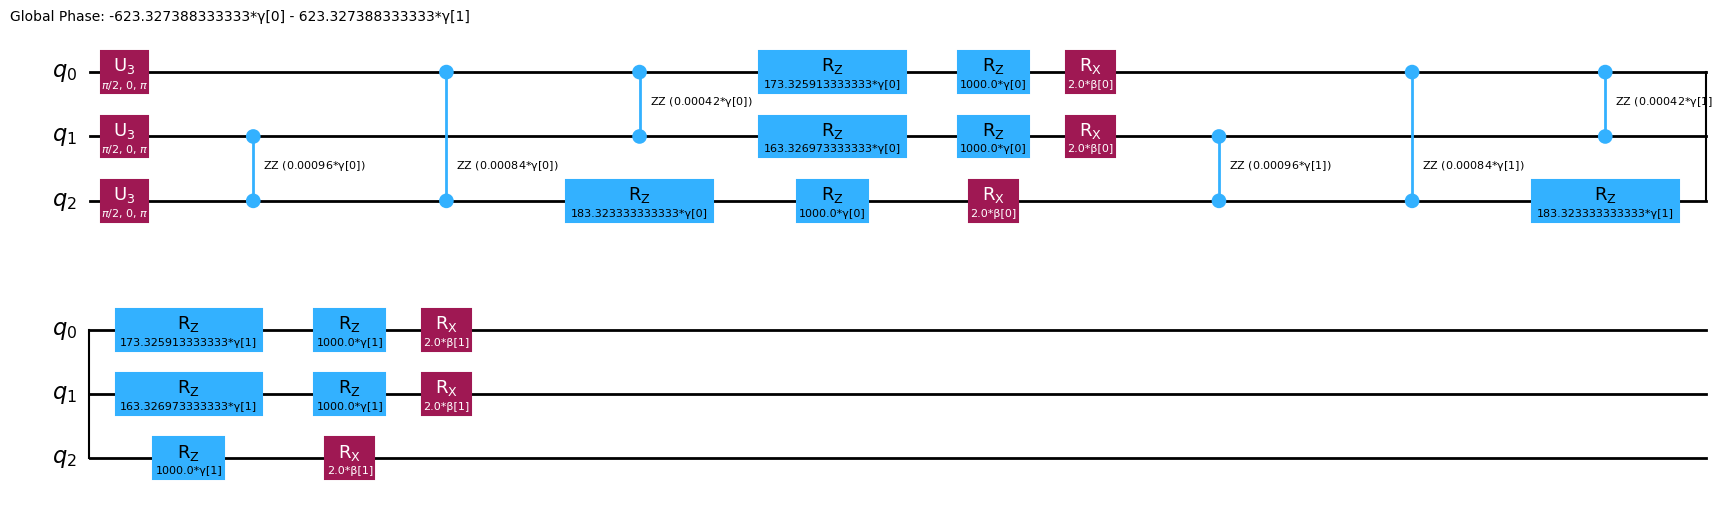

In [47]:
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)

ansatz.decompose(reps=3).draw(output="mpl", style="iqp")

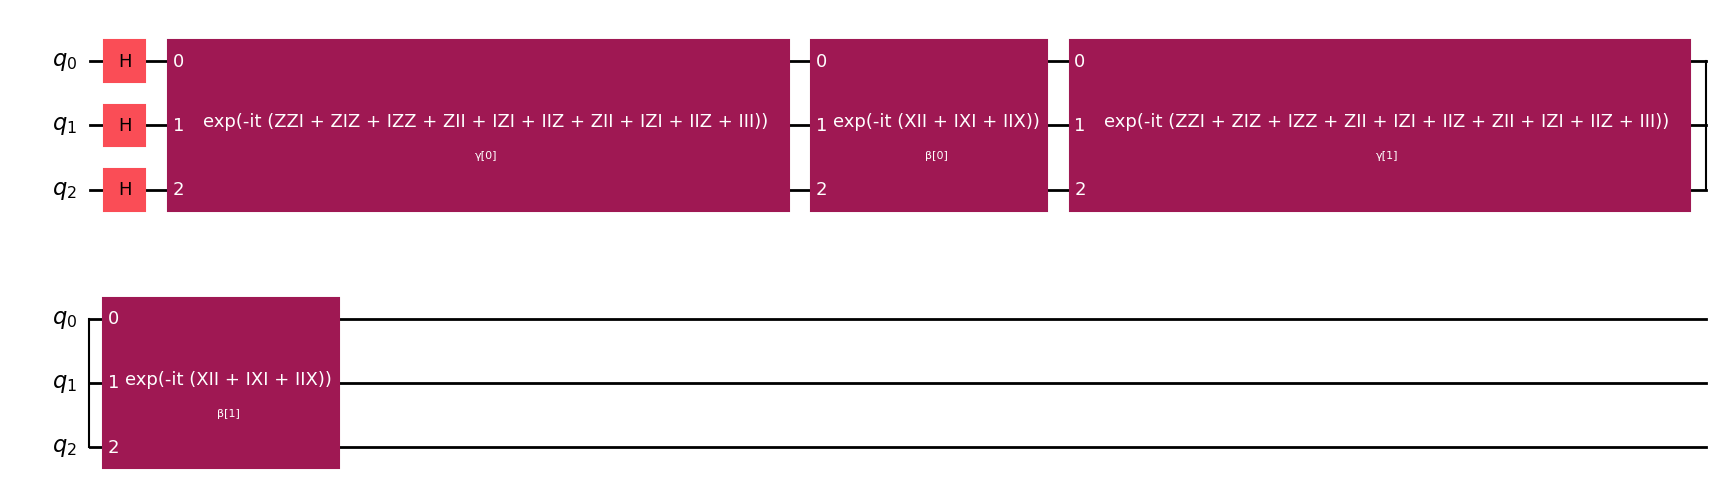

In [48]:
ansatz.decompose().draw(output="mpl", style="iqp")

In [49]:
def cost_func(params, ansatz, hamiltonian, estimator):

    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]
    return cost

In [50]:
estimator = StatevectorEstimator()
sampler = StatevectorSampler()

In [51]:
x0 = np.random.rand(ansatz.num_parameters)


In [52]:
res =  minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA") # Minimization routine

In [53]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -758.7745672696046
       x: [ 1.348e+00  5.499e-01  4.205e-01  9.975e-01]
    nfev: 43
   maxcv: 0.0

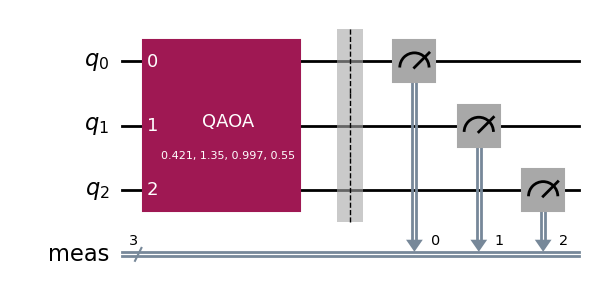

In [54]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()
qc.draw(output="mpl", idle_wires=False, style="iqp")

In [55]:
# Sample ansatz at optimal parameters
result = sampler.run([qc]).result()
samp_dist = result[0].data.meas.get_counts()

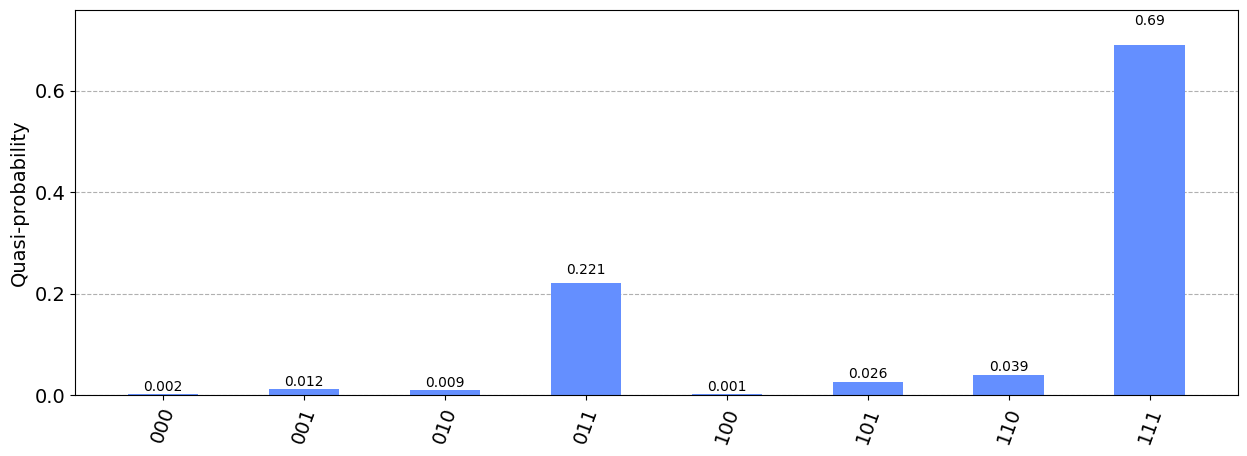

In [56]:
plot_distribution(samp_dist, figsize=(15, 5))